In [1]:
import os
import re
import xlrd
import pandas as pd
import numpy as np
import sys
#import gensim
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer, WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import randint as sp_randint
# machine learning
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import scipy.stats as st
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition, pipeline, metrics, grid_search
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import random
from sklearn import cross_validation
from sklearn.utils import shuffle


random.seed(9001)

porter_stemmer = PorterStemmer()
stemmer = SnowballStemmer("english")
stop_words = stopwords.words('english')

t0 = time.time()


os.chdir('C:\\Users\\swaroop\\Desktop\\interviews\\quantiphi')

C:\Users\swaroop\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\swaroop\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Read the data from excel to a pandas dataframe 

xl = pd.ExcelFile("Training Sheet.xlsx")

train = xl.parse(xl.sheet_names[0])
#print train.head()

xl = pd.ExcelFile("Scoring Sheet.xlsx")

test = xl.parse(xl.sheet_names[0])
#print test.head()

print test.columns

Index([u'id', u'name', u'display_name', u'production_budget',
       u'production_year', u'movie_sequel', u'creative_type', u'source',
       u'production_method', u'genre', u'language', u'board_rating_reason',
       u'movie_board_rating_display_name',
       u'movie_release_pattern_display_name'],
      dtype='object')


In [3]:
# Create features based on name and display_name

train['same_name_flag'] = train['name'] == train['display_name']
test['same_name_flag'] = test['name'] == test['display_name']

train['contains_year2'] = train["name"].apply(lambda x: 1 if '(' in str(x) else 0)
test['contains_year2'] = test["name"].apply(lambda x: 1 if '(' in str(x) else 0)

train['same_name_flag']  = train['same_name_flag'].astype(int)
test['same_name_flag'] = test["same_name_flag"].apply(lambda x: len(str(x)))

train['name_length'] = train["name"].apply(lambda x: len(str(x)))
test['name_length'] = test["name"].apply(lambda x: len(str(x)))

train['name_words_len'] = train["name"].apply(lambda x: len(str(x).strip().split()))
test['name_words_len'] = test["name"].apply(lambda x: len(str(x).strip().split()))

#train['display_name_words_len'] = train["display_name"].apply(lambda x: len(str(x).encode('utf-8').strip().split()))
#test['display_name_words_len'] = test["display_name"].apply(lambda x: len(str(x).encode('utf-8').strip().split()))


In [4]:
# Create features based on name and display_name

#removing special characters from text
stop = stopwords.words('english')

train['board_rating_reason'] = train['board_rating_reason'].str.replace(',','').replace('.','').replace('/',' ').replace(';','').replace('(','').replace(')','')
train['board_rating_reason'] = train['board_rating_reason'].str.lower()


train['board_rating_reason'] = train['board_rating_reason'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

train['name'] = train['name'].str.replace(',','').replace('.','').replace('/',' ').replace(';','').replace('(','').replace(')','')
train['name'] = train['name'].str.lower()

train['name_wno_sw'] = train['name'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stop)]))

train['name_wno_sw_length'] = train["name_wno_sw"].apply(lambda x: len(str(x)))
train['name_words_wno_sw_len'] = train["name_wno_sw"].apply(lambda x: len(str(x).strip().split()))

#Porter Stemming 
train['brr_TOKENIZED']=train['board_rating_reason'].apply(lambda x : filter(None,x.split(" ")))
train['brr_stemmed']=train['brr_TOKENIZED'].apply(lambda x : [porter_stemmer.stem(y) for y in x])
train['brr_stemmed_sentence']=train['brr_stemmed'].apply(lambda x : " ".join(x))

test['brr_TOKENIZED']=test['board_rating_reason'].apply(lambda x : filter(None,x.split(" ")))
test['brr_stemmed']=test['brr_TOKENIZED'].apply(lambda x : [porter_stemmer.stem(y) for y in x])
test['brr_stemmed_sentence']=test['brr_stemmed'].apply(lambda x : " ".join(x))


print train['brr_stemmed_sentence'][:5]

train = train.drop(['name_wno_sw', 'brr_TOKENIZED', 'brr_stemmed', 'board_rating_reason',], axis=1)
test = test.drop(['brr_TOKENIZED', 'brr_stemmed', 'board_rating_reason',], axis=1)


0    intens epic battl sequenc warfar sensual langu...
1       sequenc intens action violenc frighten images.
2    intens prolong sequenc sci-fi action violenc m...
3                                                gener
4    intens sequenc action/adventur violenc frighte...
Name: brr_stemmed_sentence, dtype: object


In [5]:
#Creating features for the first and last character of movie name

train['first_char'] = train['name'].str.lower().str[0].astype(str)
train['last_char'] = train['name'].str.lower().str[-1].astype(str)

test['first_char'] = test['name'].str.lower().str[0].astype(str)
test['last_char'] = test['name'].str.lower().str[-1].astype(str)


In [6]:
#Creating dummy variables for the categorical features and vectorizer on text

first_char_dummies_train = pd.get_dummies(train['first_char'], prefix='f_char_')
first_char_dummies_test = pd.get_dummies(test['first_char'], prefix='f_char_')

last_char_dummies_train = pd.get_dummies(train['last_char'], prefix='l_char_')
last_char_dummies_test = pd.get_dummies(test['last_char'], prefix='l_char_')

genre_dummies_train  = pd.get_dummies(train['genre'])
genre_dummies_test  = pd.get_dummies(test['genre'])

source_dummies_train  = pd.get_dummies(train['source'])
source_dummies_test  = pd.get_dummies(test['source'])

mbrdn_dummies_train  = pd.get_dummies(train['movie_board_rating_display_name'])
mbrdn_dummies_test  = pd.get_dummies(test['movie_board_rating_display_name'])

language_dummies_train  = pd.get_dummies(train['language'])
language_dummies_test  = pd.get_dummies(test['language'])

pmd_train  = pd.get_dummies(train['production_method'])
pmd_test  = pd.get_dummies(test['production_method'])

creative_type_train  = pd.get_dummies(train['creative_type'])
creative_type_test  = pd.get_dummies(test['creative_type'])

mrpdn_train  = pd.get_dummies(train['movie_release_pattern_display_name'])
mrpdn_test  = pd.get_dummies(test['movie_release_pattern_display_name'])

#tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english') # , ngram_range=(1,2)
tf_vectorizer = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 5), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

train_b_rating_reason = tf_vectorizer.fit_transform(train.brr_stemmed_sentence)
test_b_rating_reason = tf_vectorizer.transform(test.brr_stemmed_sentence)

train_vocab = pd.DataFrame(train_b_rating_reason.todense(), columns=tf_vectorizer.get_feature_names())
test_vocab = pd.DataFrame(test_b_rating_reason.todense(), columns=tf_vectorizer.get_feature_names())


name_tf_vectorizer = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 5), use_idf=1,smooth_idf=1,sublinear_tf=1, stop_words = 'english')

train_name_data = name_tf_vectorizer.fit_transform(train.name.values.astype('U'))
test_name_data = name_tf_vectorizer.transform(test.name.values.astype('U'))


train_name_vocab = pd.DataFrame(train_name_data.todense(), columns=name_tf_vectorizer.get_feature_names())
test_name_vocab = pd.DataFrame(test_name_data.todense(), columns=name_tf_vectorizer.get_feature_names())

train_name_vocab.columns = ['name_col_f_' + str(col)  for col in train_name_vocab.columns]
test_name_vocab.columns = ['name_col_f_' + str(col)  for col in test_name_vocab.columns]


In [7]:

train_df = pd.concat([train, train_vocab, train_name_vocab, first_char_dummies_train, last_char_dummies_train, genre_dummies_train, source_dummies_train, mbrdn_dummies_train, language_dummies_train, pmd_train, creative_type_train, mrpdn_train], axis=1)

test_df = pd.concat([test, test_vocab, first_char_dummies_test, last_char_dummies_test, genre_dummies_test, source_dummies_test, mbrdn_dummies_test, language_dummies_test, pmd_test, creative_type_test, mrpdn_test], axis=1)


In [8]:
#drop unnecessary columns, these columns won't be useful in analysis and prediction

train_df = train_df.drop(['id', 'name', 'first_char', 'last_char', 'total', 'display_name', 'genre','source','movie_board_rating_display_name', 'language', 'production_method', 'creative_type', 'movie_release_pattern_display_name', 'brr_stemmed_sentence'], axis=1)
test_df = test_df.drop(['id', 'name', 'first_char', 'last_char', 'production_budget','display_name', 'genre','source','movie_board_rating_display_name', 'language', 'production_method', 'creative_type', 'movie_release_pattern_display_name', 'brr_stemmed_sentence', 'production_year'], axis=1)

missing_cols = set( train_df.columns ) - set( test_df.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_df[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
score_df = test_df[train_df.columns]

score_df  = score_df.drop(["Category", "production_year"],axis=1)

print score_df.shape

time.time()-t0

(91, 1284)


1.7850000858306885

In [9]:
'''
X = train_df.drop("Category",axis=1)
Y = train_df["Category"]
X_final  = test_df.drop("Category",axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
'''

#Split the data to train and test 
train_df = shuffle(train_df)


train_df["Category"] = train['Category'].apply(lambda x : x+1 if x%2==1 else x)
train_df.loc[train_df['Category'] == 10, 'Category'] = 8
print train_df["Category"].value_counts()

X_train = train_df.loc[train_df.production_year != 2011]
X_test = train_df.loc[train_df.production_year == 2011]
Y_train = X_train["Category"]
Y_test = X_test["Category"]

X_train  = X_train.drop(["Category", "production_year"],axis=1)
X_test  = X_test.drop(["Category", "production_year"],axis=1)

print train_df.shape
print X_train.shape
print X_test.shape


#print np.any(np.isnan(X_test))
#print np.all(np.isfinite(X_test))

#print pd.isnull(X_test).sum() > 0

4    451
2    415
6    212
8    118
Name: Category, dtype: int64
(1196, 1286)
(986, 1284)
(210, 1284)


In [10]:
# Function to print best scores

from operator import itemgetter

def report(grid_scores, n_top):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print "Model with rank: {0}".format(i + 1)
        print "Mean validation score: {0:.4f})".format(score.mean_validation_score, np.std(score.cv_validation_scores))
        print "Parameters: {0}".format(score.parameters)
        print ""

In [11]:
#Logistic Regression

logistic = LogisticRegression(random_state=1)

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# Plot the PCA spectrum
pca.fit(X_train)

n_components = [20, 40, 64, 100]
Cs = np.logspace(-4, 4, 3)
a = 'ovr'
# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs, 
                              logistic__random_state=[None],
                              logistic__intercept_scaling=[1.0],
                              logistic__tol=[0.00001],
                              logistic__dual=[True],
                              logistic__multi_class=['ovr'],
                            logistic__class_weight =['balanced']))
estimator.fit(X_train, Y_train)

best_model = estimator.best_estimator_
print best_model    
    
print(" Test Accuracy: %.2f%%" % (accuracy_score(Y_test, best_model.predict(X_test)) * 100.0))
#print(" Train Accuracy: %.2f%%" % (accuracy_score(Y_train, best_model.predict(X_train)) * 100.0))
report(estimator.grid_scores_, 4)

Pipeline(steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=64, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=1.0, class_weight='balanced', dual=True,
          fit_intercept=True, intercept_scaling=1.0, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=1e-05, verbose=0, warm_start=False))])
 Test Accuracy: 58.10%
Model with rank: 1
Mean validation score: 0.5142)
Parameters: {'logistic__tol': 1e-05, 'pca__n_components': 64, 'logistic__dual': True, 'logistic__class_weight': 'balanced', 'logistic__C': 1.0, 'logistic__random_state': None, 'logistic__intercept_scaling': 1.0, 'logistic__multi_class': 'ovr'}

Model with rank: 2
Mean validation score: 0.5132)
Parameters: {'logistic__tol': 1e-05, 'pca__n_components': 20, 'logistic__dual': True, 'logistic__class_weight': 'balanced', 'logistic__C': 1.0, 'logistic__random_state': None, 'logistic__intercept_scal

In [12]:
# SVC with SVD

svd = TruncatedSVD()
    
scl = StandardScaler()
    
svm_model = SVC(random_state=1)
    
clf = pipeline.Pipeline([('svd', svd), ('scl', scl), ('svm', svm_model)])
    
    
param_grid = {'svd__n_components' : [10, 15, 20, 25, 30, 35, 40, 70], 'svm__C': [0.1, 1, 9,10, 12, 100], 
                'svm__decision_function_shape': ['ovr']}
    
model = grid_search.GridSearchCV(estimator = clf, param_grid=param_grid, scoring='accuracy', verbose=0, n_jobs=-1, iid=True, refit=True, cv=10)
                                     

model.fit(X_train, Y_train)
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
    
best_model = model.best_estimator_
    
print best_model
#best_model.fit(Xtrain,Y_train)
#preds = best_model.predict(X_test)
    
print(" Test Accuracy: %.2f%%" % (accuracy_score(Y_test, best_model.predict(X_test)) * 100.0))
#print(" Train Accuracy: %.2f%%" % (accuracy_score(Y_train, best_model.predict(X_train)) * 100.0))   

report(model.grid_scores_, 5)

Best score: 0.542
Best parameters set:
	svd__n_components: 20
	svm__C: 1
	svm__decision_function_shape: 'ovr'
Pipeline(steps=[('svd', TruncatedSVD(algorithm='randomized', n_components=20, n_iter=5,
       random_state=None, tol=0.0)), ('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False))])
 Test Accuracy: 56.19%
Model with rank: 1
Mean validation score: 0.5416)
Parameters: {'svm__C': 1, 'svm__decision_function_shape': 'ovr', 'svd__n_components': 20}

Model with rank: 2
Mean validation score: 0.5375)
Parameters: {'svm__C': 1, 'svm__decision_function_shape': 'ovr', 'svd__n_components': 15}

Model with rank: 3
Mean validation score: 0.5355)
Parameters: {'svm__C': 1, 'svm__decision_function_shape': 'ovr', 'svd__n_components': 35}

Model with rank: 4
Me

In [14]:
#XGBoost Classifier with GridSearch

params={
    'max_depth': [2,3,5,7,9], #[3,4,5,6,7,8,9], # 5 is good 
    'subsample': [0.4,0.5,0.6,0.7,0.8,0.9,1.0], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'colsample_bytree': [0.5,0.6,0.7,0.8,0.9,1.0], #[0.5,0.6,0.7,0.8],
    'n_estimators': [3, 40, 100, 500, 1000], #[1000,2000,3000]
    #"n_estimators": st.randint(3, 40),
    'reg_alpha': [0, 0.03, 0.1, 0.5, 1.0] #[0.01, 0.02, 0.03, 0.04]
}



xgb_clf = xgb.XGBClassifier()
rs = RandomizedSearchCV(xgb_clf,
                  params,
                  cv=6,
                  scoring="accuracy",
                  n_jobs=-1,
                  verbose=1)
rs.fit(X_train, Y_train)
best_est = rs.best_estimator_
print(best_est)


print(" Test Accuracy: %.2f%%" % (accuracy_score(Y_test, best_est.predict(X_test)) * 100.0))
#print(" Train Accuracy: %.2f%%" % (accuracy_score(Y_train, best_est.predict(X_train)) * 100.0))

report(rs.grid_scores_, 10)

Fitting 6 folds for each of 10 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 21.8min finished


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=3, nthread=-1,
       objective='multi:softprob', reg_alpha=0.1, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)
 Test Accuracy: 59.52%
Model with rank: 1
Mean validation score: 0.5325)
Parameters: {'n_estimators': 3, 'subsample': 0.9, 'reg_alpha': 0.1, 'colsample_bytree': 0.7, 'max_depth': 9}

Model with rank: 2
Mean validation score: 0.5294)
Parameters: {'n_estimators': 3, 'subsample': 0.4, 'reg_alpha': 0.5, 'colsample_bytree': 0.5, 'max_depth': 5}

Model with rank: 3
Mean validation score: 0.5223)
Parameters: {'n_estimators': 3, 'subsample': 0.6, 'reg_alpha': 0.03, 'colsample_bytree': 0.9, 'max_depth': 5}

Model with rank: 4
Mean validation score: 0.5112)
Parameters: {'n_estimators': 500, 'subsample': 0.8, 'reg_alpha': 0.1, 'colsample_bytree': 0.5, 'max_depth': 5}


C:\Users\swaroop\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [15]:
#Random Forest
random.seed(9001)

clf = RandomForestClassifier()


param_dist = {"max_depth": [3, 5, 6, 7, 8, 9],
              "max_features": [6, 10, 15, 20, 30, None],
              "min_samples_split": [2, 5, 10, 15, 100,120],
              "min_samples_leaf": [1, 2, 4, 5, 6, 7],
              "class_weight": ['balanced'],
              "n_estimators": [50,100, 120, 150,250,300],
               "oob_score": [True],
                "random_state": [9001]}

# run randomized search
#n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, cv=8, scoring='accuracy',  n_jobs=-1)
                                   #n_iter=n_iter_search)


random_search.fit(X_train, Y_train)


best_est = random_search.best_estimator_
print best_est

print(" Test Accuracy: %.2f%%" % (accuracy_score(Y_test, best_est.predict(X_test)) * 100.0))
#print(" Train Accuracy: %.2f%%" % (accuracy_score(Y_train, best_est.predict(X_train)) * 100.0))

report(random_search.grid_scores_, 6)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features=10,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=True, random_state=9001, verbose=0, warm_start=False)
 Test Accuracy: 57.62%
Model with rank: 1
Mean validation score: 0.5416)
Parameters: {'oob_score': True, 'min_samples_leaf': 1, 'n_estimators': 300, 'max_features': 10, 'random_state': 9001, 'min_samples_split': 15, 'max_depth': 7, 'class_weight': 'balanced'}

Model with rank: 2
Mean validation score: 0.5406)
Parameters: {'oob_score': True, 'min_samples_leaf': 5, 'n_estimators': 150, 'max_features': 10, 'random_state': 9001, 'min_samples_split': 10, 'max_depth': 6, 'class_weight': 'balanced'}

Model with rank: 3
Mean validation score: 0.5385)
Parameters: {'oob_score': True, 'min_samples_leaf': 4, 'n_estimators

C:\Users\swaroop\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [16]:
importances = best_est.feature_importances_

feat_labels = list(X_train.columns.values)

# Print the name and gini importance of each feature
#for feature in zip(feat_labels, clf.feature_importances_):
#    print(feature)
    
sfm = SelectFromModel(best_est, threshold=0.001)

# Train the selector
sfm.fit(X_train, Y_train)

cols = []

for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])


movie_sequel
same_name_flag
name_length
name_words_len
name_wno_sw_length
name_words_wno_sw_len
action
action languag
action rude humor
action sexual content
action violenc
action violenc brief
action violenc frighten
action violenc languag
action violenc mild
action violence
adventur
adventur action
adventur violenc
art
audienc
battl sequenc
bloodi
bloodi violenc
bloodi violenc pervas languag
brief
brief mild
brief sensual
brief strong
brief strong languag
content
content languag
content languag nuditi
content nuditi
crude
crude humor
crude sexual
crude sexual content
dialogu
disast
disturb
disturb imag
disturb violent
drug
element
exclud
fantasi
fantasi action
fi
fi action
fi action violenc
fi action violenc brief
frighten
frighten imag
gener
horror
humor
humor languag drug
imag
imag brief
imag languag
imag language
includ
includ disturb
intens
intens action
intens sequenc
intens sequenc action
intens sequenc action violenc
intens sequenc sci
intens sequenc sci fi
intens sequenc sci 

In [20]:
# My predictions
best_est.predict(score_df) 

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 4, 8, 8, 6, 4, 4, 8, 4, 6, 6, 8, 2,
       8, 4, 4, 6, 8, 4, 4, 2, 6, 4, 4, 4, 2, 2, 6, 2, 4, 4, 4, 4, 2, 4, 2,
       2, 2, 2, 4, 2, 6, 4, 8, 2, 6, 2, 4, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

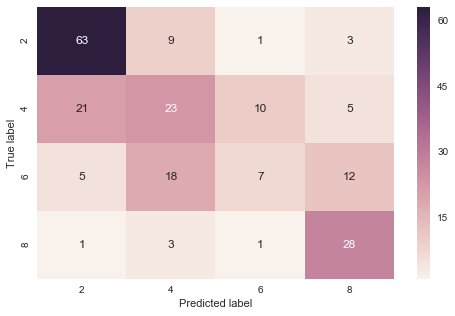

In [18]:
cm = confusion_matrix(Y_test, best_est.predict(X_test))

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['2','4','6','8'], 
                     columns = ['2','4','6','8'])

plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt="d")
#plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()